In [1]:
#Python/Data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import cv2
import numpy as np
import uproot as ur
import pandas as pd
import awkward as ak
import compress_pickle
from matplotlib import style
from multiprocessing import Process, Queue,Manager,set_start_method

import os
import shutil
import sys

# This guide can only be run with the tensorflow backend.
os.environ["KERAS_BACKEND"] = "tensorflow"

#ML
import energyflow as ef
#from energyflow.archs import PFN
from energyflow.utils import data_split
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import mplhep as hep

#Use Hybrid class for taining
import gradientBoost_hybrid_model as gbhm

label='npyfiles'
path='./'+label
if not os.path.isdir(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)

In [2]:
inputdir='datafiles/'
testfileName=inputdir+'Kplus_5GeV_etaneg2.0_phirand_10Kevts_4ML.root'
with ur.open(testfileName) as file:
    tree=file['Events']
    '''
    Save entire TBranch that contains TObject as Pandas DataFrame
    All Class member will be save to dataframe
    Specify members to save by:
    dataf=tree.arr(["Class.Memember1","Class.member2"],library="pd")
    '''
    dataf=tree.arrays(library="pd")

print(dataf.head(7))

   pdgID        posX        posY     posZ      momX      momY      momZ  \
0    321  462.165308  111.049556 -1682.01  1.290471  0.311895 -4.816862   
1    321 -351.104717 -297.808128 -1682.01 -1.007502 -0.859484 -4.816800   
2     11  488.916502   33.553512 -1682.01 -0.000004  0.000629 -0.000883   
3     11 -442.589131 -102.294178 -1682.01  0.000519 -0.000304 -0.000427   
4    321  169.628514  441.180908 -1682.01  0.483527  1.232211 -4.813647   
5    321 -229.730884 -388.171098 -1682.01 -0.677152 -1.139246 -4.817527   
6    321  194.622817 -418.093805 -1682.01  0.547329 -1.209395 -4.813226   

           pT       eta     theta       phi      time  
0  475.319656 -1.976296  2.866184  0.235811  5.996743  
1  460.395703 -2.007031  2.874419 -2.438143  5.828637  
2  490.066510 -1.946928  2.858083  0.068521  6.179884  
3  454.256797 -2.019984  2.877818 -2.914454  5.852819  
4  472.667352 -1.981682  2.867644  1.203734  5.951665  
5  451.057735 -2.026809  2.879591 -2.105186  5.690704  
6  461.

In [3]:
#Ceate features and target for training the data
file_name=inputdir+'Kplus_5GeV_etaneg2.0_phirand_10Kevts_4ML.root'
tree_name='Events'
branch_name=('posX','posY')
features=['posX','posY','posZ','momX','momY','momZ','pT','eta','theta','phi','time']
particle_name=["piplus", "Kplus", "proton","All"]
energy=[2,3,4,5,6,7,8,9,10]
target='pdgID'
hist_name=particle_name[1]+"_"+str(energy[3])+"GeV_XY"

hybrid_model=gbhm.GradientBoostHybrid(file_name,tree_name,branch_name,hist_name,features,target,max_events=350000)
tree_df=hybrid_model._load_data()
print(tree_df.head(7))

         posX        posY     posZ      momX      momY      momZ          pT  \
0  462.165308  111.049556 -1682.01  1.290471  0.311895 -4.816862  475.319656   
1 -351.104717 -297.808128 -1682.01 -1.007502 -0.859484 -4.816800  460.395703   
2  488.916502   33.553512 -1682.01 -0.000004  0.000629 -0.000883  490.066510   
3 -442.589131 -102.294178 -1682.01  0.000519 -0.000304 -0.000427  454.256797   
4  169.628514  441.180908 -1682.01  0.483527  1.232211 -4.813647  472.667352   
5 -229.730884 -388.171098 -1682.01 -0.677152 -1.139246 -4.817527  451.057735   
6  194.622817 -418.093805 -1682.01  0.547329 -1.209395 -4.813226  461.172929   

        eta     theta       phi      time  pdgID  bin_index      radius  
0 -1.976296  2.866184  0.235811  5.996743    321       1413  475.319656  
1 -2.007031  2.874419 -2.438143  5.828637    321        648  460.395703  
2 -1.946928  2.858083  0.068521  6.179884     11       1267  490.066510  
3 -2.019984  2.877818 -2.914454  5.852819     11        987  45

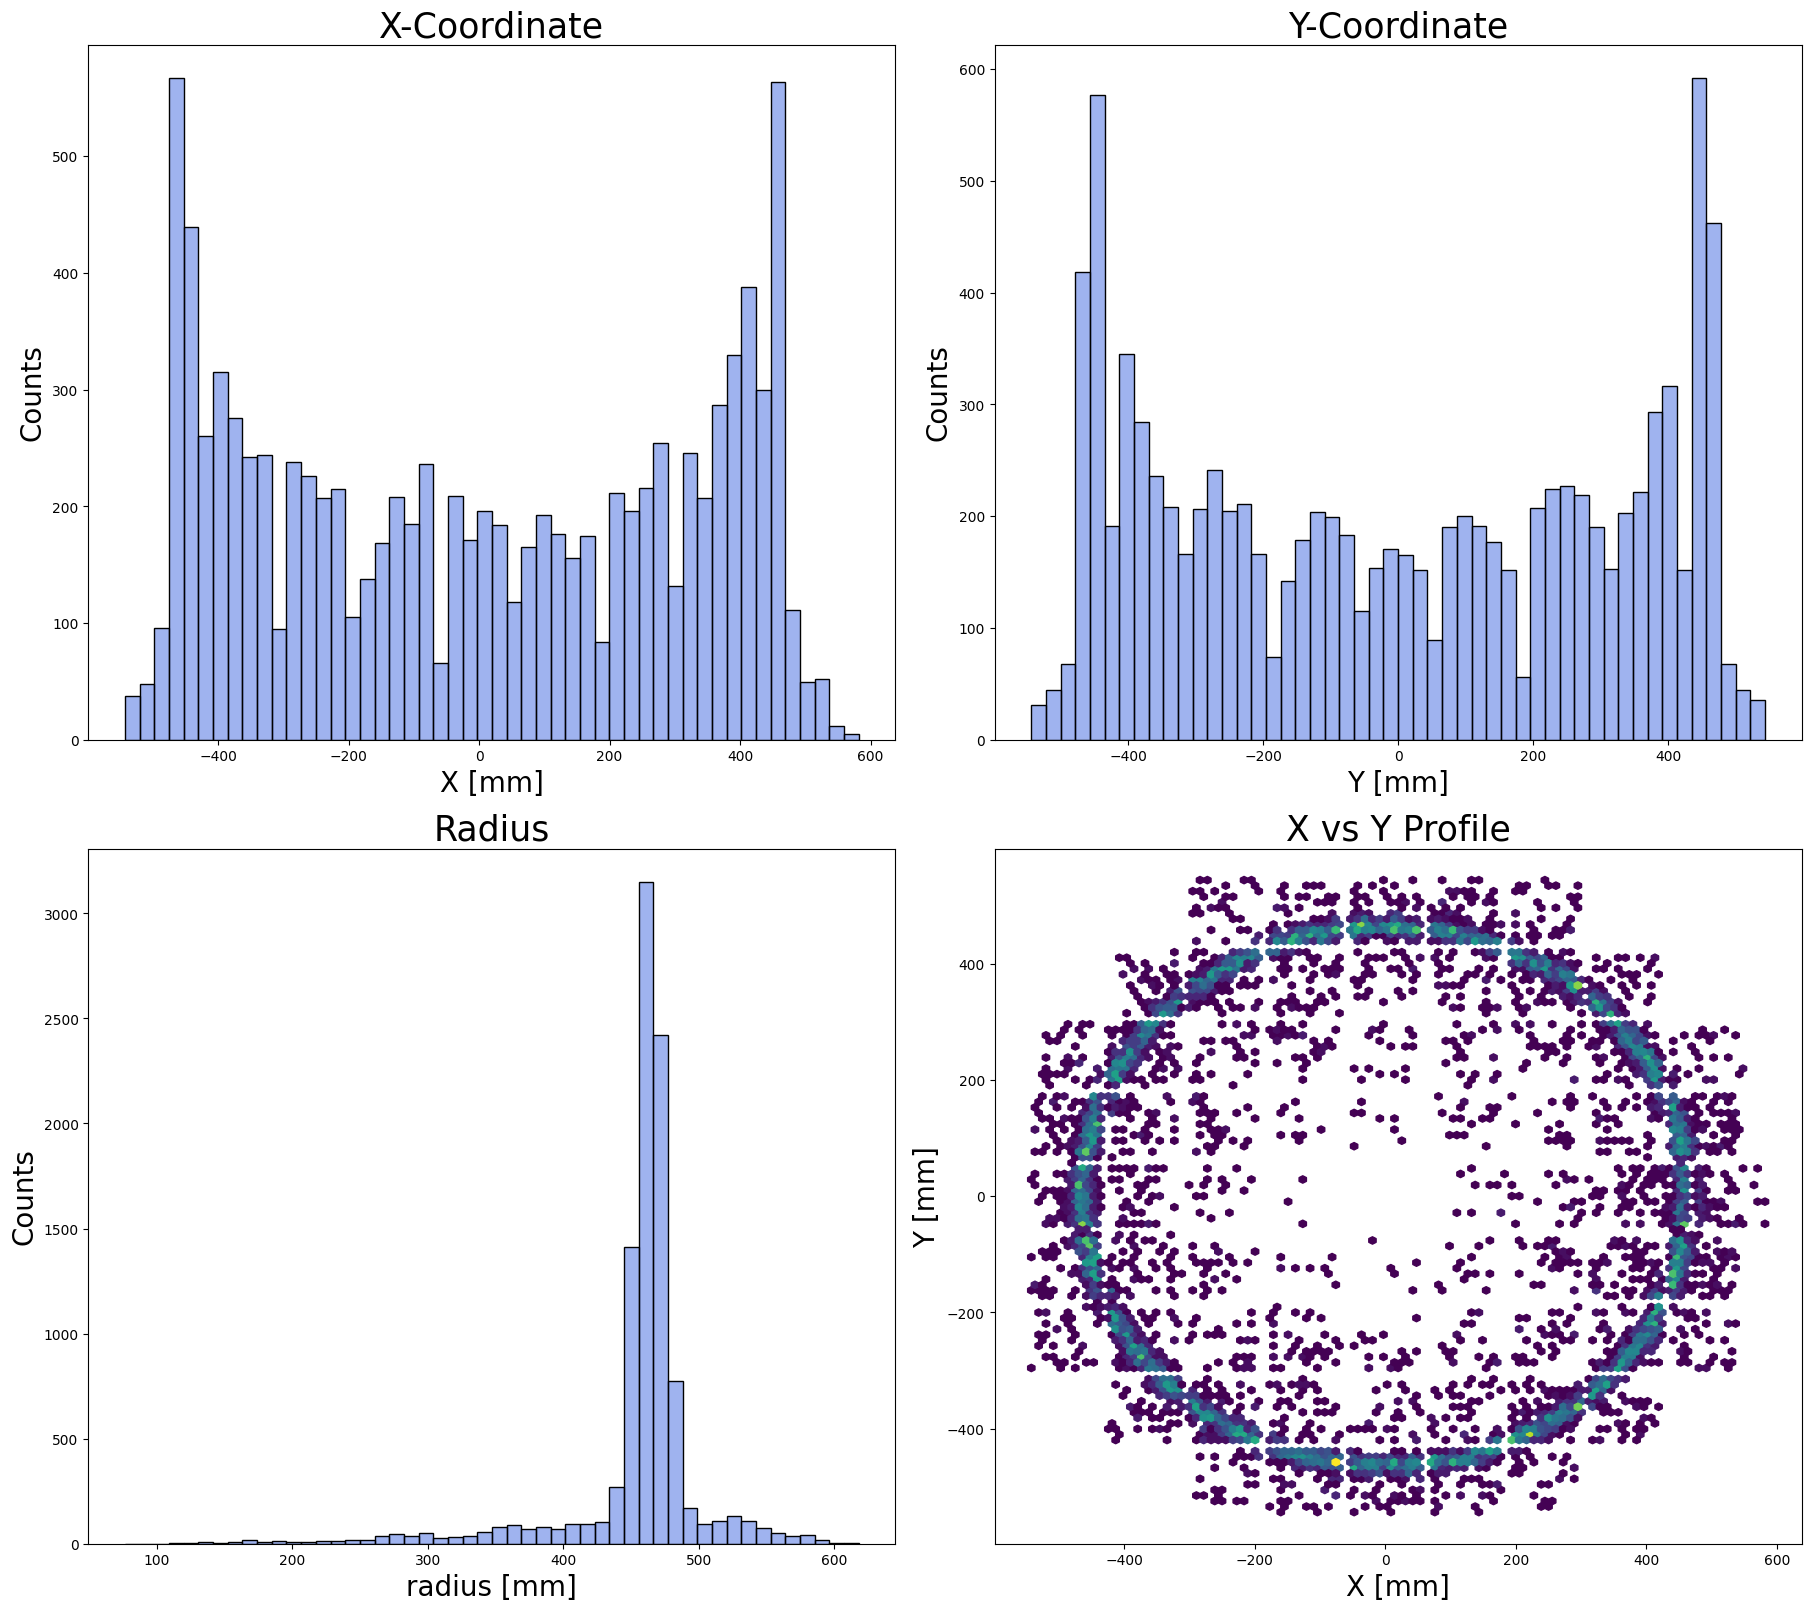

In [4]:
x1=tree_df["posX"]
y1=tree_df["posY"]

radius1=np.sqrt(x1*x1+y1*y1)
fig1,axes1=plt.subplots(nrows=2,ncols=2,figsize=(18,16),constrained_layout=True)
sns.histplot(tree_df['posX'],bins=50,color='royalblue',
    edgecolor='black',linewidth=1.0,alpha=0.5,ax=axes1[0,0])
#axes1[0,0].hist(tree_df['posX'],bins=50,alpha=0.5)
axes1[0,0].set_xlabel("X [mm]",fontsize=20)
axes1[0,0].set_ylabel("Counts",fontsize=20)
axes1[0,0].set_title("X-Coordinate",fontsize=25)

sns.histplot(tree_df['posY'],bins=50,kde=False,color='royalblue',
    edgecolor='black',linewidth=1.0,alpha=0.5,ax=axes1[0,1])
#axes1[0,1].hist(tree_df['posY'],bins=50,alpha=0.5)
axes1[0,1].set_xlabel("Y [mm]",fontsize=20)
axes1[0,1].set_ylabel("Counts",fontsize=20)
axes1[0,1].set_title("Y-Coordinate",fontsize=25)

sns.histplot(radius1,bins=50,kde=False,color='royalblue',
    edgecolor='black',linewidth=1.0,alpha=0.5,ax=axes1[1,0])
#axes1[1,0].hist(radius1,bins=50,alpha=0.5)
axes1[1,0].set_xlabel("radius [mm]",fontsize=20)
axes1[1,0].set_ylabel("Counts",fontsize=20)
axes1[1,0].set_title("Radius",fontsize=25)

axes1[1,1].hexbin(tree_df['posX'],tree_df['posY'],gridsize=100,cmap='viridis',mincnt=1)
axes1[1,1].set_xlabel("X [mm]",fontsize=20)
axes1[1,1].set_ylabel("Y [mm]",fontsize=20)
axes1[1,1].set_title("X vs Y Profile",fontsize=25)

plt.show()

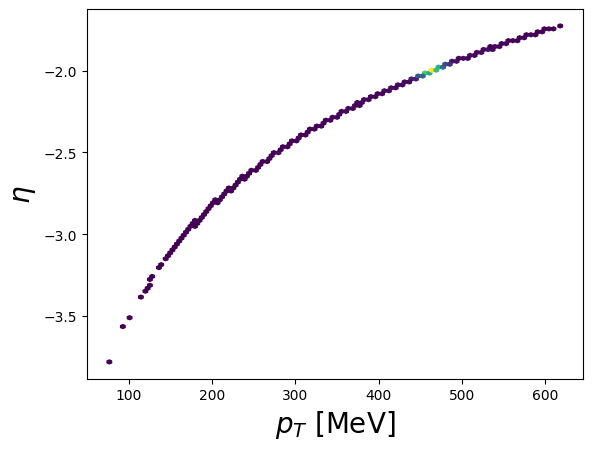

In [5]:
plt.hexbin(tree_df['pT'],tree_df['eta'],gridsize=100,cmap='viridis',mincnt=1)
plt.xlabel("$p_{T}$ [MeV]",fontsize=20)
plt.ylabel("$\\eta$",fontsize=20)
plt.show()

In [ ]:
train=hybrid_model.gbhm_train()

Training Gradient Boosting model...


In [6]:
hybrid_model.xgb_train()

Training XGBoost model...
[0]	train-mlogloss:1.61877	test-mlogloss:1.62102
[1]	train-mlogloss:1.38801	test-mlogloss:1.39161
[2]	train-mlogloss:1.20964	test-mlogloss:1.21493
[3]	train-mlogloss:1.06493	test-mlogloss:1.07184
[4]	train-mlogloss:0.94423	test-mlogloss:0.95278
[5]	train-mlogloss:0.84172	test-mlogloss:0.85157
[6]	train-mlogloss:0.75365	test-mlogloss:0.76422
[7]	train-mlogloss:0.67664	test-mlogloss:0.68860
[8]	train-mlogloss:0.60913	test-mlogloss:0.62223
[9]	train-mlogloss:0.54969	test-mlogloss:0.56388
[10]	train-mlogloss:0.49714	test-mlogloss:0.51216
[11]	train-mlogloss:0.45062	test-mlogloss:0.46652
[12]	train-mlogloss:0.40883	test-mlogloss:0.42589
[13]	train-mlogloss:0.37138	test-mlogloss:0.38950
[14]	train-mlogloss:0.33788	test-mlogloss:0.35697
[15]	train-mlogloss:0.30785	test-mlogloss:0.32810
[16]	train-mlogloss:0.28077	test-mlogloss:0.30196
[17]	train-mlogloss:0.25663	test-mlogloss:0.27857
[18]	train-mlogloss:0.23459	test-mlogloss:0.25740
[19]	train-mlogloss:0.21463	test-m

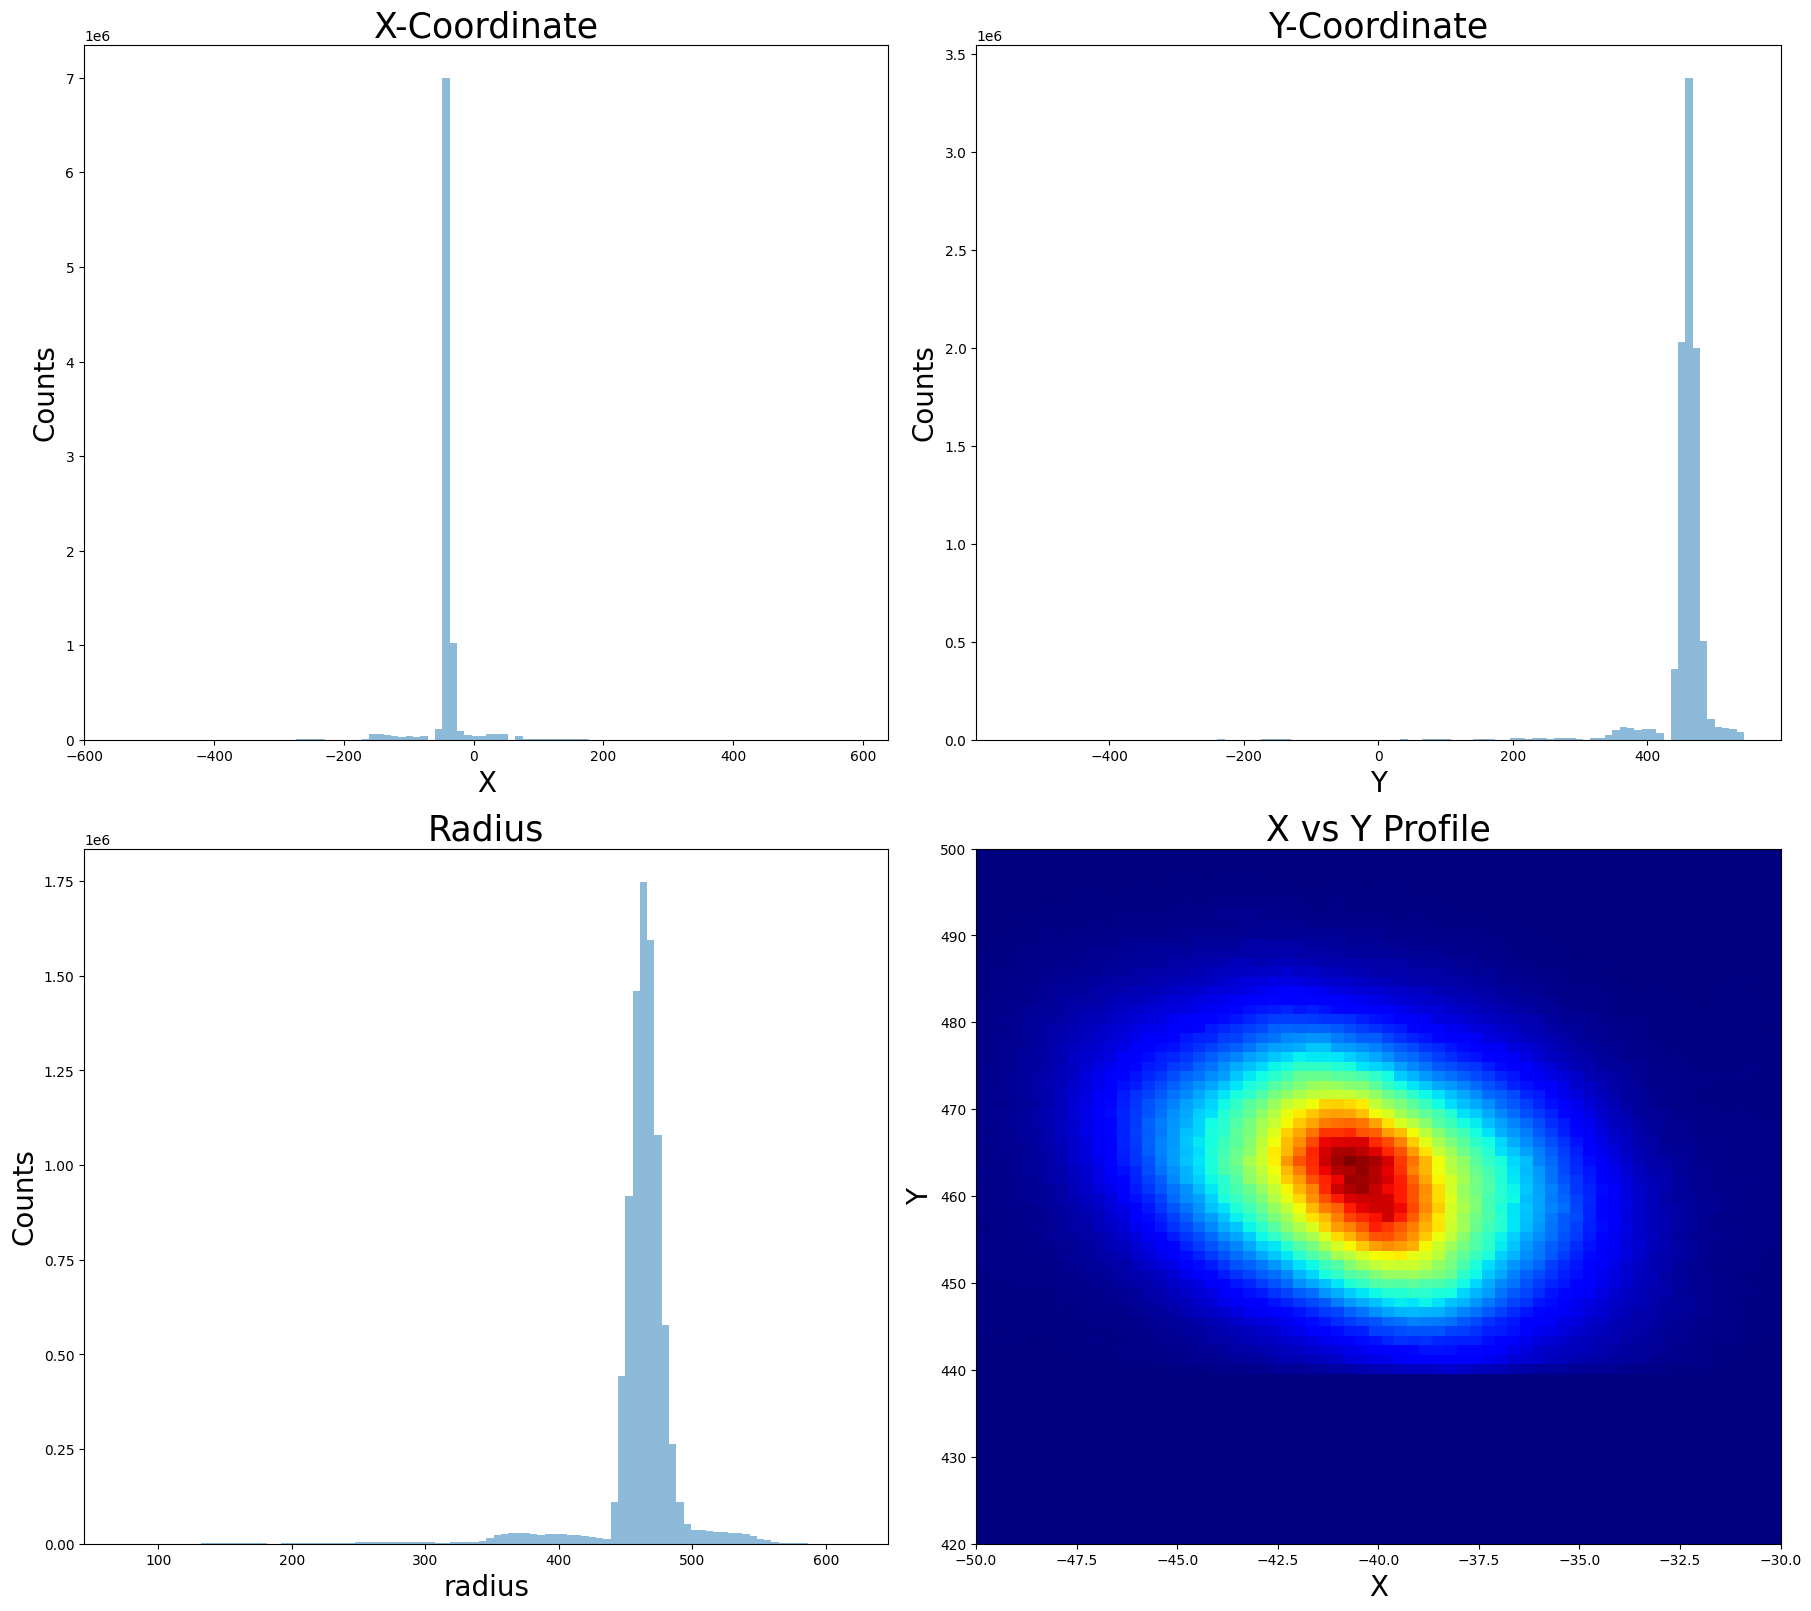

In [5]:
#Create filtered dataframe for values of t>0
filtered_dataf=tree_df[tree_df['time']>0]

x=filtered_dataf["posX"]
y=filtered_dataf["posY"]
radius=np.sqrt(x*x+y*y)
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(18,16),constrained_layout=True)
axes[0,0].hist(filtered_dataf['posX'],bins=100,alpha=0.5)
axes[0,0].set_xlabel("X",fontsize=20)
axes[0,0].set_ylabel("Counts",fontsize=20)
axes[0,0].set_title("X-Coordinate",fontsize=25)

axes[0,1].hist(filtered_dataf['posY'],bins=100,alpha=0.5)
axes[0,1].set_xlabel("Y",fontsize=20)
axes[0,1].set_ylabel("Counts",fontsize=20)
axes[0,1].set_title("Y-Coordinate",fontsize=25)

axes[1,0].hist(radius,bins=100,alpha=0.5)
axes[1,0].set_xlabel("radius",fontsize=20)
axes[1,0].set_ylabel("Counts",fontsize=20)
axes[1,0].set_title("Radius",fontsize=25)

axes[1,1].hist2d(filtered_dataf['posX'],filtered_dataf['posY'],bins=(3600,1000),cmap=plt.cm.jet)
axes[1,1].set_xlim(-50,-30)
axes[1,1].set_ylim(420,500)
axes[1,1].set_xlabel("X",fontsize=20)
axes[1,1].set_ylabel("Y",fontsize=20)
axes[1,1].set_title("X vs Y Profile",fontsize=25)

#plt.colorbar(im,label='counts')
plt.show()

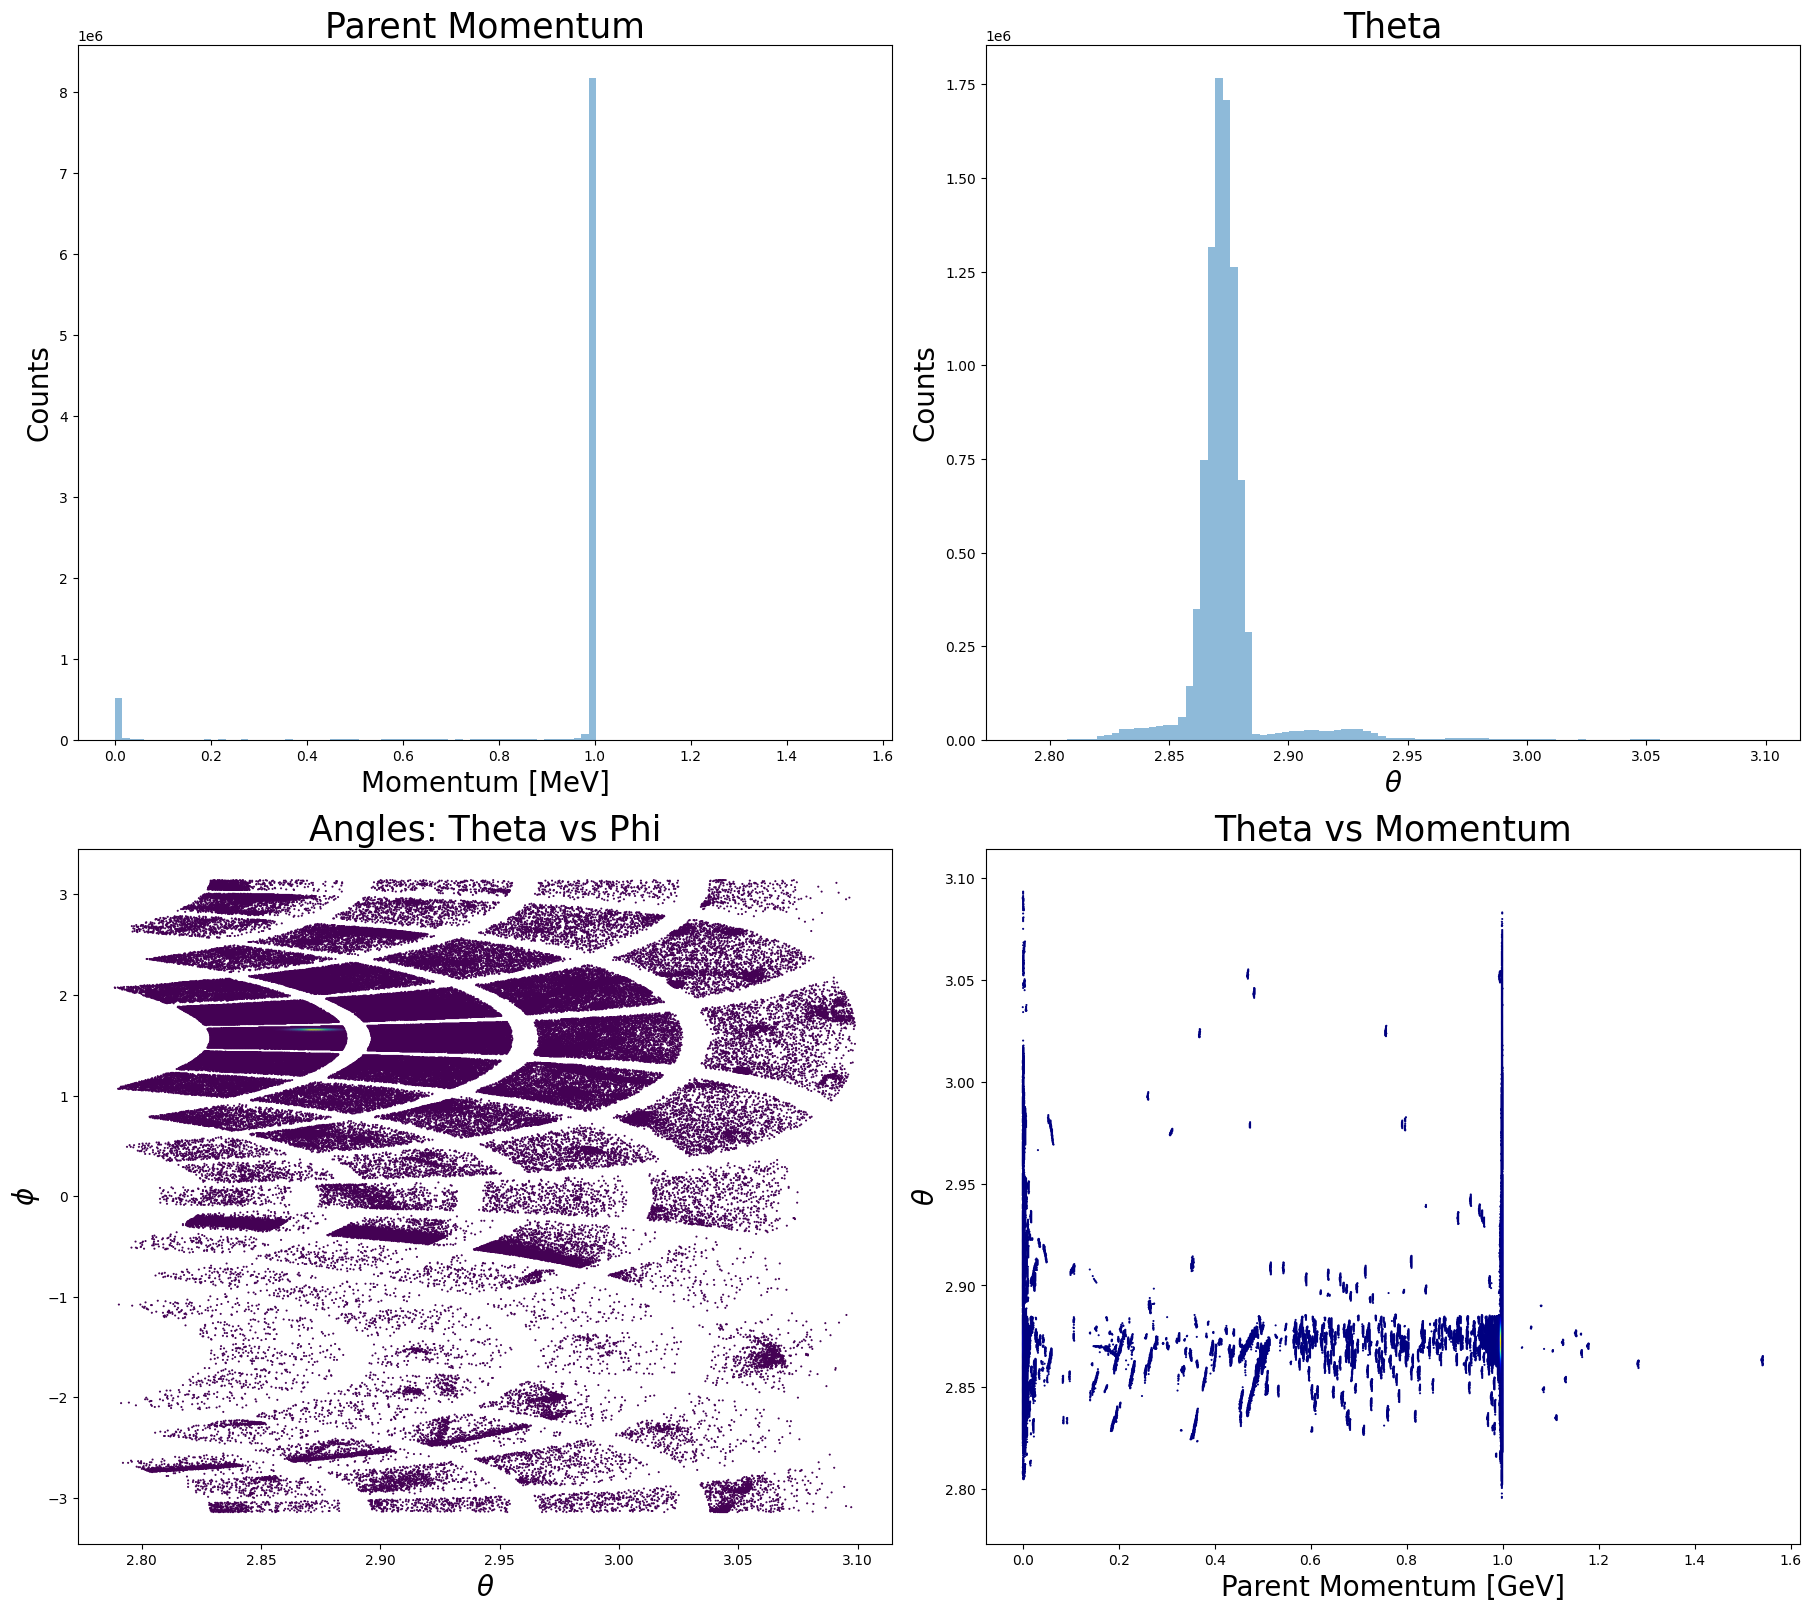

In [6]:
px=filtered_dataf['momX']
py=filtered_dataf['momY']
pz=filtered_dataf['momZ']

p=np.sqrt(px*px+py*py+pz*pz)

fig2,axes2=plt.subplots(nrows=2,ncols=2,figsize=(18,16),constrained_layout=True)
axes2[0,0].hist(p,bins=100,alpha=0.5)
axes2[0,0].set_xlabel("Momentum [MeV]",fontsize=20)
axes2[0,0].set_ylabel("Counts",fontsize=20)
axes2[0,0].set_title("Parent Momentum",fontsize=25)

axes2[0,1].hist(filtered_dataf['theta'],bins=100,alpha=0.5)
axes2[0,1].set_xlabel("$\\theta$",fontsize=20)
axes2[0,1].set_ylabel("Counts",fontsize=20)
axes2[0,1].set_title("Theta",fontsize=25)

axes2[1,0].hexbin(filtered_dataf['theta'],filtered_dataf['phi'],gridsize=1000,cmap='viridis',mincnt=1)
axes2[1,0].set_xlabel("$\\theta$",fontsize=20)
axes2[1,0].set_ylabel("$\\phi$",fontsize=20)
axes2[1,0].set_title("Angles: Theta vs Phi",fontsize=25)

axes2[1,1].hexbin(p,filtered_dataf['theta'],gridsize=1000,cmap=plt.cm.jet,mincnt=10)
axes2[1,1].set_ylabel("$\\theta$",fontsize=20)
axes2[1,1].set_xlabel("Parent Momentum [GeV]",fontsize=20)
axes2[1,1].set_title("Theta vs Momentum",fontsize=25)

#plt.colorbar(im,label='counts')
plt.show()

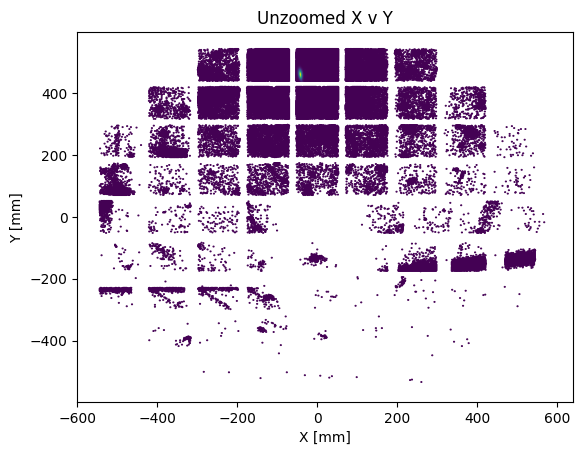

In [8]:
plt.hexbin(filtered_dataf['posX'],filtered_dataf['posY'],gridsize=600,cmap='viridis',mincnt=2)
#plt.hist2d(filtered_dataf['posX'],filtered_dataf['posY'],bins=(3600,1000),cmap=plt.cm.jet)
plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.title('Unzoomed X v Y')
plt.show()